# Clip a Xarray Dataset Using a Polygon
Clipping is a more complex procedure but is easy to achieve using the process in this notebook. Any polygon can be used including a multipolygon.

The example in this notebook clips the pixel data using a rectangular region in the centre of the study area. All time steps are clipped simultaneously.

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray

# For masking using shapefile
from shapely.geometry import mapping

## Read the Pixel Data into Xarray

In [3]:
ds = xr.open_dataset('../Data/netCDF/ds_BM_NP.nc')
ds

<xarray.Dataset>
Dimensions:      (time: 36, y: 200, x: 170)
Coordinates:
  * y            (y) float64 4.466e+06 4.466e+06 ... 4.447e+06 4.447e+06
  * x            (x) float64 9.604e+06 9.604e+06 9.604e+06 ... 9.62e+06 9.62e+06
    spatial_ref  int32 ...
  * time         (time) datetime64[ns] 2018-01-31 2018-02-28 ... 2020-12-31
Data variables:
    nbart_red    (time, y, x) float32 ...
    nbart_blue   (time, y, x) float32 ...
    nbart_green  (time, y, x) float32 ...
    nbart_nir_1  (time, y, x) float32 ...
Attributes:
    crs:           EPSG:3308
    grid_mapping:  spatial_ref

## Read the Vector Data and set the CRS
For the clipping process to work the pixel and vector data have to bein the same coordinate reference system (CRS). Notice that the CRS for the pixel dataset is EPSG:3308. The vector data needs to be set to this CRS before clipping.

In [4]:
poly = gpd.read_file('../Data/Vector/clip/clip.shp')
poly.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
poly = poly.to_crs(crs=3308)
poly.crs

<Projected CRS: EPSG:3308>
Name: GDA94 / NSW Lambert
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Australia - New South Wales.
- bounds: (140.99, -37.53, 153.69, -28.15)
Coordinate Operation:
- name: New South Wales Lambert
- method: Lambert Conic Conformal (2SP)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Clip a Data Array
Our dataset consists of a data array for each of the four data bands. The following process will clip a data array and not the entire dataset. Apply this process recursively to clip a dataset.

In [7]:
nbart_red_clip = ds.nbart_red.rio.clip(poly.geometry.apply(mapping), 
                        poly.crs, drop=False)

Plot a subset of the original data array and the clipped data array for comparison.

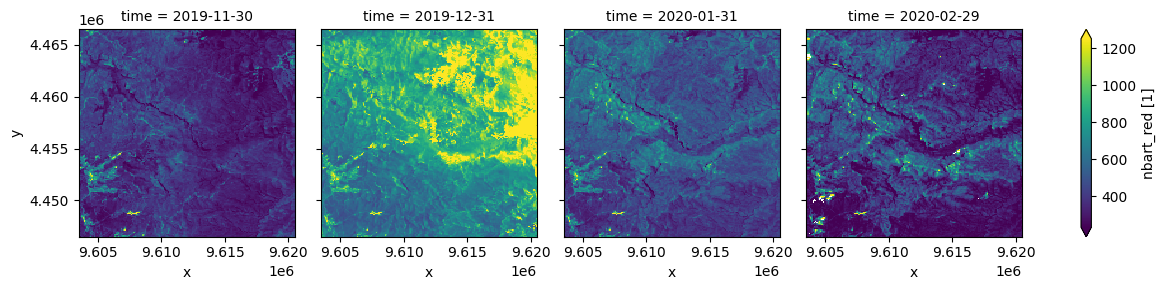

In [69]:
ds.nbart_red.sel(time=slice('2019-11','2020-02')).plot(col='time', robust=True)

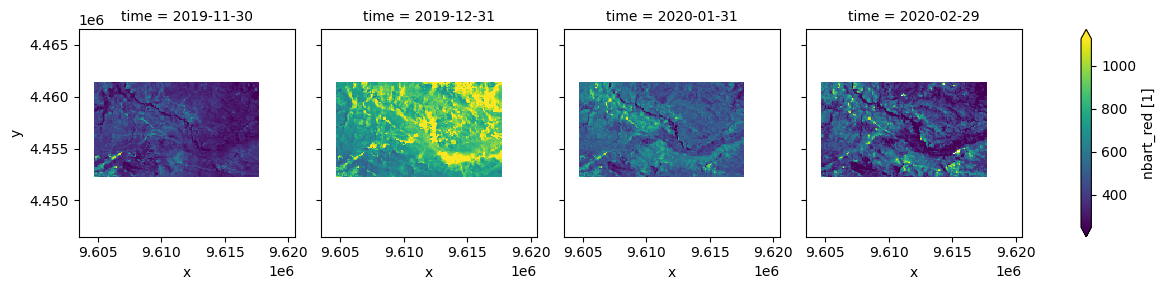

In [68]:
nbart_red_clip.sel(time=slice('2019-11','2020-02')).plot(col='time', robust=True)

## Clip the Whole Dataset
The whole dataset can be clipped by creating a function from the process above and applying it to each data array in the dataset.

In [14]:
def clip_da(da, geom):
    '''
    Clip a dataset by applying the clipping process to each data array recursively.
    '''
    return da.rio.clip(geom.geometry.apply(mapping), geom.crs, drop=False)

Test the function by applying it to the nbart_red band as before.

In [16]:
nbart_red_clip = clip_da(da=ds.nbart_red, geom=poly)

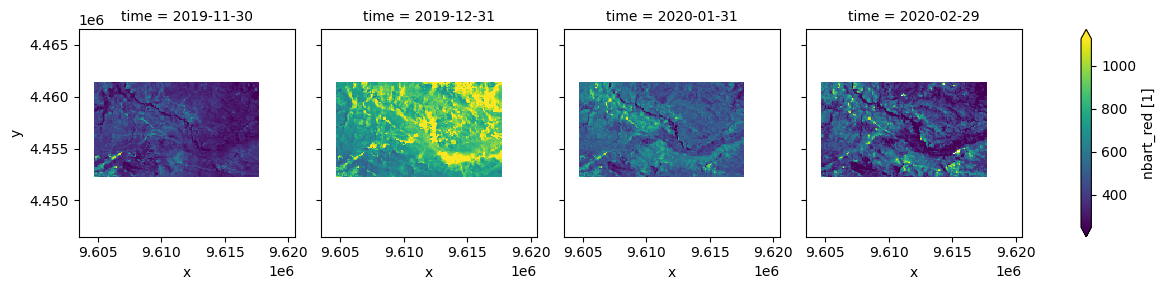

In [67]:
nbart_red_clip.sel(time=slice('2019-11','2020-02')).plot(col='time', robust=True)

The next step is to apply the function to each band in the dataset. A dictionary comprehension is used to create the clipped data arrays which are then used to make the final dataset.

In [61]:
var_dict={var: clip_da(da=ds[var], geom=poly) for var in ds.data_vars}

In [62]:
ds_clip = xr.Dataset(var_dict)

In [63]:
ds_clip

<xarray.Dataset>
Dimensions:      (y: 200, x: 170, time: 36)
Coordinates:
  * y            (y) float64 4.466e+06 4.466e+06 ... 4.447e+06 4.447e+06
  * x            (x) float64 9.604e+06 9.604e+06 9.604e+06 ... 9.62e+06 9.62e+06
  * time         (time) datetime64[ns] 2018-01-31 2018-02-28 ... 2020-12-31
    spatial_ref  int32 0
Data variables:
    nbart_red    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_blue   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_green  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_nir_1  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

Now check the data by creating a RGB facetgrid plot.

C:\Users\mjdea\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


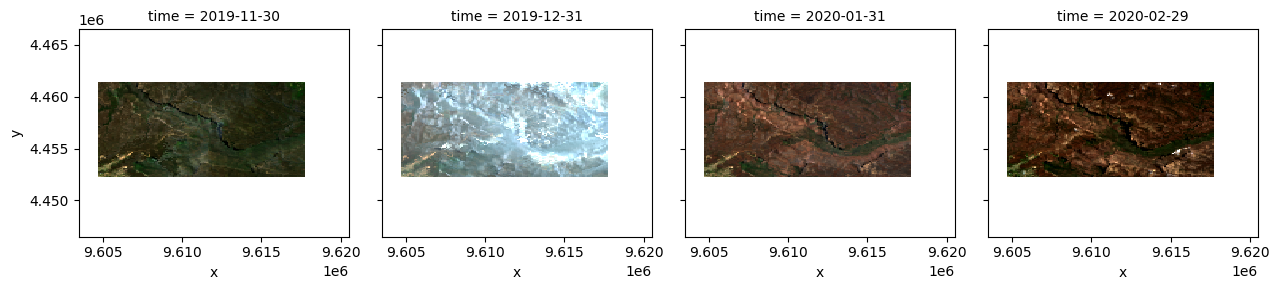

In [65]:
(ds_clip[['nbart_red','nbart_green','nbart_blue']].sel(time=slice('2019-11', '2020-02'))
 .to_dataarray()
 .plot.imshow(col='time', robust=True))